In [1]:
from google.colab import drive
drive.mount('/content/drive')

import requests, os

EXPR_PATH    = "/content/drive/MyDrive/tcga_RSEM_gene_fpkm.gz"
PHENOTYPE_PATH = "/content/drive/MyDrive/tcga_phenotype.tsv.gz"

PC_URL  = "https://raw.githubusercontent.com/CBIIT/TULIP/main/gene_lists/protein_coding_genes.txt"
PC_PATH = "/content/drive/MyDrive/protein_coding_genes.txt"

if not os.path.exists(PC_PATH):
    response = requests.get(PC_URL)
    with open(PC_PATH, "wb") as f:
        f.write(response.content)
else:
    print("list already exists")

with open(PC_PATH) as f:
    protein_coding_genes = set(line.strip() for line in f)

print(f"genes: {len(protein_coding_genes):,}")

Mounted at /content/drive
list already exists
genes: 19,758


In [2]:
import pandas as pd
import numpy as np

pc_genes_df = pd.read_csv(PC_PATH, sep="\t", header=None, names=["gene_id", "gene_name"])

pc_genes_df["gene_id_base"] = pc_genes_df["gene_id"].str.split('.').str[0]
pc_gene_ids = set(pc_genes_df["gene_id_base"].tolist())

raw_peek = pd.read_csv(EXPR_PATH, sep="\t", index_col=0, nrows=5).iloc[:, :5]
print(raw_peek)

                    TCGA-19-1787-01  TCGA-S9-A7J2-01  TCGA-G3-A3CH-11  \
sample                                                                  
ENSG00000242268.2           -9.9658          -0.3940          -9.9658   
ENSG00000259041.1           -9.9658          -9.9658          -9.9658   
ENSG00000270112.3           -4.2934          -3.8160          -9.9658   
ENSG00000167578.16           4.8324           4.1962           3.3952   
ENSG00000278814.1           -9.9658          -9.9658          -9.9658   

                    TCGA-EK-A2RE-01  TCGA-44-6778-01  
sample                                                
ENSG00000242268.2           -9.9658          -9.9658  
ENSG00000259041.1           -9.9658          -9.9658  
ENSG00000270112.3           -9.9658          -6.5064  
ENSG00000167578.16           3.9099           4.9031  
ENSG00000278814.1           -9.9658          -9.9658  


In [3]:
import pandas as pd

labels_full = pd.read_csv(PHENOTYPE_PATH, sep="\t", index_col=0)

print(f"total samples in phenotype file: {len(labels_full)}")
print(f"columns: {list(labels_full.columns)}")

primary_mask = labels_full["sample_type"] == "Primary Tumor"
primary_tumor_idx = labels_full[primary_mask].index

print(f"primary tumor samples: {len(primary_tumor_idx)}")

print(f"unique tumor types in _primary_disease:")
tumor_types = labels_full.loc[primary_tumor_idx, "_primary_disease"].astype(str).str.strip().str.lower()
print(f"total unique: {tumor_types.nunique()}")
print(tumor_types.value_counts())

total samples in phenotype file: 12804
columns: ['sample_type_id', 'sample_type', '_primary_disease']
primary tumor samples: 10593
unique tumor types in _primary_disease:
total unique: 32
_primary_disease
breast invasive carcinoma                1101
glioblastoma multiforme                   594
ovarian serous cystadenocarcinoma         592
uterine corpus endometrioid carcinoma     547
kidney clear cell carcinoma               536
head & neck squamous cell carcinoma       528
lung adenocarcinoma                       520
brain lower grade glioma                  516
thyroid carcinoma                         507
lung squamous cell carcinoma              506
prostate adenocarcinoma                   498
stomach adenocarcinoma                    478
colon adenocarcinoma                      461
bladder urothelial carcinoma              412
liver hepatocellular carcinoma            377
cervical & endocervical cancer            308
kidney papillary cell carcinoma           291
sarcoma      

In [4]:
import gc

chunk_size = 5000
expr_chunks = []

for chunk in pd.read_csv(EXPR_PATH, sep="\t", index_col=0, chunksize=chunk_size):
    chunk.index = chunk.index.str.split('.').str[0]

    pc_in_chunk = chunk.index.intersection(pc_gene_ids)
    if len(pc_in_chunk) == 0:
        continue
    chunk = chunk.loc[pc_in_chunk]

    chunk_T = chunk.T
    chunk_filtered = chunk_T.loc[chunk_T.index.intersection(primary_tumor_idx)]

    if len(chunk_filtered) == 0:
        continue

    expr_chunks.append(chunk_filtered)

    if len(expr_chunks) % 3 == 0:
        genes_so_far = sum(c.shape[1] for c in expr_chunks)
        samples_so_far = expr_chunks[0].shape[0] if expr_chunks else 0

expr_full = pd.concat(expr_chunks, axis=1).astype(np.float32)
expr_full.index.name = "sample"

del expr_chunks
gc.collect()

print(f"expression matrix:")
print(f"shape: {expr_full.shape}")
print(f"genes matched: {expr_full.shape[1]:,} / {len(pc_gene_ids):,}")
print(f"samples matched: {expr_full.shape[0]:,} / {len(primary_tumor_idx):,}")

expr_full = (2.0 ** expr_full) - 1.0
expr_full[expr_full < 0] = 0

expression matrix:
shape: (9185, 19740)
genes matched: 19,740 / 19,758
samples matched: 9,185 / 10,593


In [5]:
shared = expr_full.index.intersection(primary_tumor_idx)
expr   = expr_full.loc[shared]
labels = labels_full.loc[shared]

del expr_full
gc.collect()

print(f"aligned primary tumor samples: {len(shared)}")
print(f"expression: {expr.shape}")
print(f"labels: {labels.shape}")

aligned primary tumor samples: 9185
expression: (9185, 19740)
labels: (9185, 3)


In [6]:
TULIP_32_TUMOR_TYPES = [
    "uveal melanoma",
    "adrenocortical cancer",
    "bladder urothelial carcinoma",
    "brain lower grade glioma",
    "breast invasive carcinoma",
    "cervical & endocervical cancer",
    "cholangiocarcinoma",
    "colon adenocarcinoma",
    "diffuse large b-cell lymphoma",
    "esophageal carcinoma",
    "glioblastoma multiforme",
    "head & neck squamous cell carcinoma",
    "kidney chromophobe",
    "kidney clear cell carcinoma",
    "kidney papillary cell carcinoma",
    "liver hepatocellular carcinoma",
    "lung adenocarcinoma",
    "lung squamous cell carcinoma",
    "mesothelioma",
    "ovarian serous cystadenocarcinoma",
    "pancreatic adenocarcinoma",
    "pheochromocytoma & paraganglioma",
    "prostate adenocarcinoma",
    "rectum adenocarcinoma",
    "sarcoma",
    "skin cutaneous melanoma",
    "stomach adenocarcinoma",
    "testicular germ cell tumor",
    "thymoma",
    "thyroid carcinoma",
    "uterine carcinosarcoma",
    "uterine corpus endometrioid carcinoma",
]

y_raw = labels["_primary_disease"].astype(str).str.strip().str.lower()

in_data     = set(y_raw.unique())
in_tulip    = set(TULIP_32_TUMOR_TYPES)
print(f"unique tumor types:  {len(in_data)}")

print(f"in our data but not in TULIP list:")
for item in sorted(in_data - in_tulip):
    print(f"{item}")

print(f"in TULIP list but not in our data:")
for item in sorted(in_tulip - in_data):
    print(f"{item}")

mask = y_raw.isin(TULIP_32_TUMOR_TYPES)
expr   = expr.loc[mask]
y_raw  = y_raw.loc[mask]
labels = labels.loc[mask]

print(f"after filtering to 32 TULIP types:")
print(f"samples: {len(expr):,}")
print(f"classes: {y_raw.nunique()}")
print("class distribution:")
print(y_raw.value_counts().sort_index())

unique tumor types:  32
in our data but not in TULIP list:
in TULIP list but not in our data:
after filtering to 32 TULIP types:
samples: 9,185
classes: 32
class distribution:
_primary_disease
adrenocortical cancer                      77
bladder urothelial carcinoma              407
brain lower grade glioma                  509
breast invasive carcinoma                1092
cervical & endocervical cancer            304
cholangiocarcinoma                         36
colon adenocarcinoma                      288
diffuse large b-cell lymphoma              47
esophageal carcinoma                      181
glioblastoma multiforme                   153
head & neck squamous cell carcinoma       518
kidney chromophobe                         66
kidney clear cell carcinoma               530
kidney papillary cell carcinoma           288
liver hepatocellular carcinoma            369
lung adenocarcinoma                       513
lung squamous cell carcinoma              498
mesothelioma             

In [7]:

print(f"input shape: {expr.shape}")

row_sums = expr.sum(axis=1)
expr = expr.div(row_sums, axis=0) * 1_000_000

expr[expr <= 0] = 0.000001

expr = expr.astype(np.float64).apply(np.log10).astype(np.float32)

expr[expr < 0] = 0

print(f"value range after log10(TPM): [{expr.values.min():.4f}, {expr.values.max():.4f}]")

n_genes = expr.shape[1]
PAD_TARGET = 19800
n_pad = PAD_TARGET - n_genes
if n_pad > 0:
    pad_cols = pd.DataFrame(
        np.zeros((len(expr), n_pad), dtype=np.float32),
        index=expr.index,
        columns=[f"PAD_{i}" for i in range(n_pad)]
    )
    expr = pd.concat([expr, pad_cols], axis=1)
elif n_pad < 0:
    expr = expr.iloc[:, :PAD_TARGET]

gc.collect()

X = expr.to_numpy(dtype=np.float32, copy=False)

del expr
gc.collect()

print(f"X shape: {X.shape}")

input shape: (9185, 19740)
value range after log10(TPM): [0.0000, 5.6057]
X shape: (9185, 19800)


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y  = le.fit_transform(y_raw)

NUM_CLASSES = len(le.classes_)
NUM_GENES   = X.shape[1]

print(f"NUM_CLASSES: {NUM_CLASSES}")
print(f"NUM_GENES: {NUM_GENES}")
print(f"Classes: {le.classes_}")

NUM_CLASSES: 32
NUM_GENES: 19800
Classes: ['adrenocortical cancer' 'bladder urothelial carcinoma'
 'brain lower grade glioma' 'breast invasive carcinoma'
 'cervical & endocervical cancer' 'cholangiocarcinoma'
 'colon adenocarcinoma' 'diffuse large b-cell lymphoma'
 'esophageal carcinoma' 'glioblastoma multiforme'
 'head & neck squamous cell carcinoma' 'kidney chromophobe'
 'kidney clear cell carcinoma' 'kidney papillary cell carcinoma'
 'liver hepatocellular carcinoma' 'lung adenocarcinoma'
 'lung squamous cell carcinoma' 'mesothelioma'
 'ovarian serous cystadenocarcinoma' 'pancreatic adenocarcinoma'
 'pheochromocytoma & paraganglioma' 'prostate adenocarcinoma'
 'rectum adenocarcinoma' 'sarcoma' 'skin cutaneous melanoma'
 'stomach adenocarcinoma' 'testicular germ cell tumor' 'thymoma'
 'thyroid carcinoma' 'uterine carcinosarcoma'
 'uterine corpus endometrioid carcinoma' 'uveal melanoma']


In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

n_samples = len(y)
indices = np.arange(n_samples)

idx_train, idx_temp = train_test_split(
    indices,
    test_size=0.20,
    random_state=42,
    stratify=y
)

idx_val, idx_test = train_test_split(
    idx_temp,
    test_size=0.50,
    random_state=42,
    stratify=y[idx_temp]
)

X_train = X[idx_train]
y_train = y[idx_train]

X_val = X[idx_val]
y_val = y[idx_val]

X_test = X[idx_test]
y_test = y[idx_test]

del X, idx_train, idx_temp, idx_val, idx_test
gc.collect()

print(f"train: {X_train.shape}")
print(f"val: {X_val.shape}")
print(f"test: {X_test.shape}")

train: (7348, 19800)
val: (918, 19800)
test: (919, 19800)


In [10]:
from torch.utils.data import Dataset, DataLoader
import torch

class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]),
            torch.tensor(self.y[idx], dtype=torch.long)
        )

batch_size = 128

train_loader = DataLoader(
    NumpyDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    NumpyDataset(X_val, y_val),
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    NumpyDataset(X_test, y_test),
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [11]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

SEQ_LEN    = 198
INPUT_SIZE = NUM_GENES // SEQ_LEN
PROJ_DIM   = SEQ_LEN * INPUT_SIZE

class LSTMClassifier(nn.Module):
    def __init__(self, num_genes, seq_len, input_size,
                 hidden_size, num_layers, num_classes, dropout=0.3):
        super().__init__()
        self.seq_len    = seq_len
        self.input_size = input_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )

        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.dropout    = nn.Dropout(dropout)
        self.fc         = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = x.view(-1, self.seq_len, self.input_size)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        x = self.layer_norm(x)
        x = self.dropout(x)
        return self.fc(x)


model = LSTMClassifier(
    num_genes   = NUM_GENES,
    seq_len     = SEQ_LEN,
    input_size  = INPUT_SIZE,
    hidden_size = 128,
    num_layers  = 2,
    num_classes = NUM_CLASSES,
    dropout     = 0.3
).to(device)

Using device: cuda


In [12]:
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

EPOCHS              = 60
EARLY_STOP_PATIENCE = 10

best_val_acc     = 0.0
patience_counter = 0
train_losses     = []
val_accs         = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out  = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds  = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)
    val_acc = correct / total
    val_accs.append(val_acc)
    scheduler.step(1 - val_acc)

    print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_lstm.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

print(f"Best validation accuracy: {best_val_acc:.4f}")

Epoch   1 | Loss: 2.3767 | Val Acc: 0.7407
Epoch   2 | Loss: 0.8581 | Val Acc: 0.8540
Epoch   3 | Loss: 0.5167 | Val Acc: 0.8889
Epoch   4 | Loss: 0.3958 | Val Acc: 0.8954
Epoch   5 | Loss: 0.3303 | Val Acc: 0.9194
Epoch   6 | Loss: 0.2991 | Val Acc: 0.9205
Epoch   7 | Loss: 0.2585 | Val Acc: 0.9237
Epoch   8 | Loss: 0.2387 | Val Acc: 0.9227
Epoch   9 | Loss: 0.2203 | Val Acc: 0.9336
Epoch  10 | Loss: 0.2189 | Val Acc: 0.9314
Epoch  11 | Loss: 0.1972 | Val Acc: 0.9346
Epoch  12 | Loss: 0.1780 | Val Acc: 0.9325
Epoch  13 | Loss: 0.1703 | Val Acc: 0.9357
Epoch  14 | Loss: 0.1720 | Val Acc: 0.9281
Epoch  15 | Loss: 0.1551 | Val Acc: 0.9292
Epoch  16 | Loss: 0.1442 | Val Acc: 0.9357
Epoch  17 | Loss: 0.1351 | Val Acc: 0.9357
Epoch  18 | Loss: 0.1081 | Val Acc: 0.9401
Epoch  19 | Loss: 0.1067 | Val Acc: 0.9390
Epoch  20 | Loss: 0.0931 | Val Acc: 0.9357
Epoch  21 | Loss: 0.0882 | Val Acc: 0.9444
Epoch  22 | Loss: 0.0915 | Val Acc: 0.9412
Epoch  23 | Loss: 0.0833 | Val Acc: 0.9423
Epoch  24 |

In [13]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

model.load_state_dict(torch.load("best_lstm.pt"))
model.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

all_preds = np.array(all_preds)
all_true  = np.array(all_true)

test_acc = np.mean(all_preds == all_true)
print(f"Test Accuracy: {test_acc:.4f}")
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=le.classes_, zero_division=0))

Test Accuracy: 0.9434
Classification Report:
                                       precision    recall  f1-score   support

                adrenocortical cancer       1.00      1.00      1.00         7
         bladder urothelial carcinoma       0.91      1.00      0.95        41
             brain lower grade glioma       0.98      1.00      0.99        51
            breast invasive carcinoma       1.00      0.99      1.00       109
       cervical & endocervical cancer       0.97      0.94      0.95        31
                   cholangiocarcinoma       0.50      0.67      0.57         3
                 colon adenocarcinoma       0.75      0.93      0.83        29
        diffuse large b-cell lymphoma       1.00      1.00      1.00         4
                 esophageal carcinoma       1.00      0.61      0.76        18
              glioblastoma multiforme       0.94      0.94      0.94        16
  head & neck squamous cell carcinoma       0.91      0.96      0.93        52
      

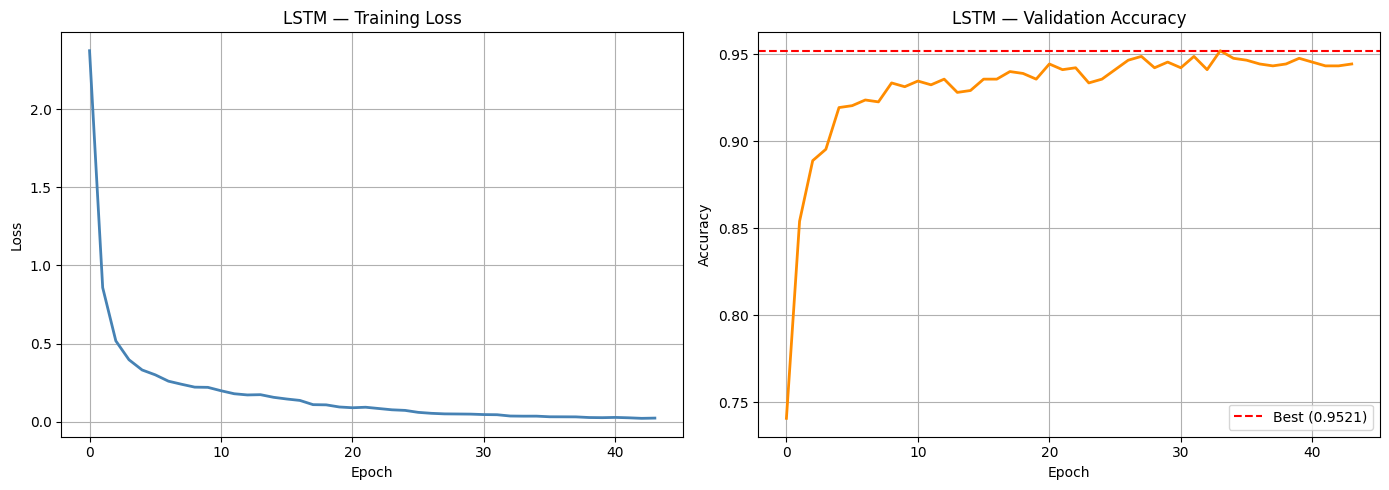

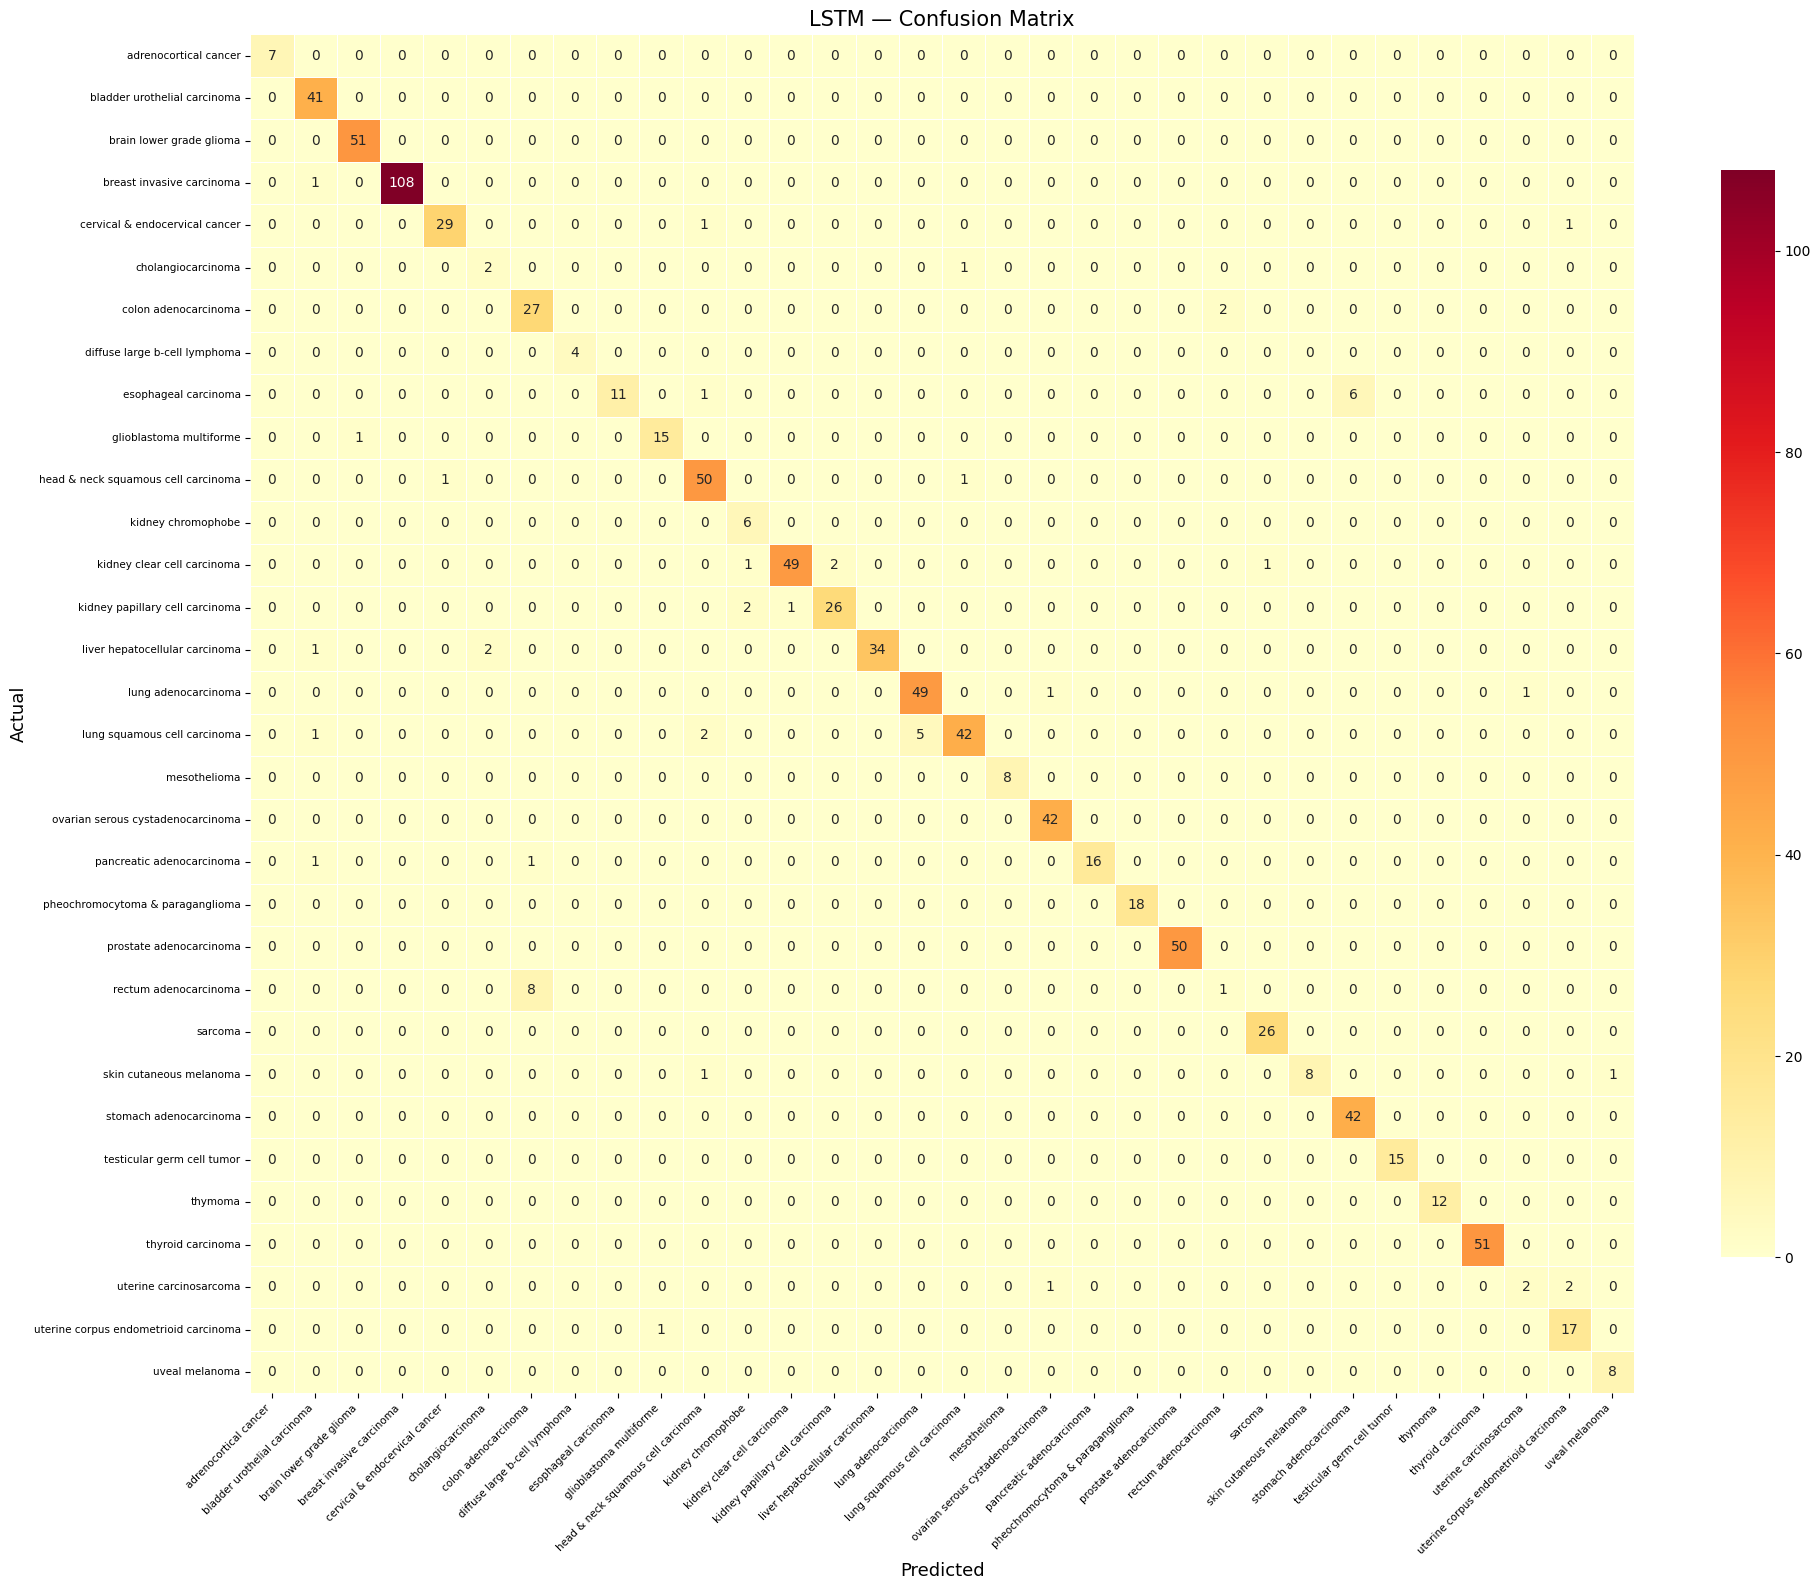

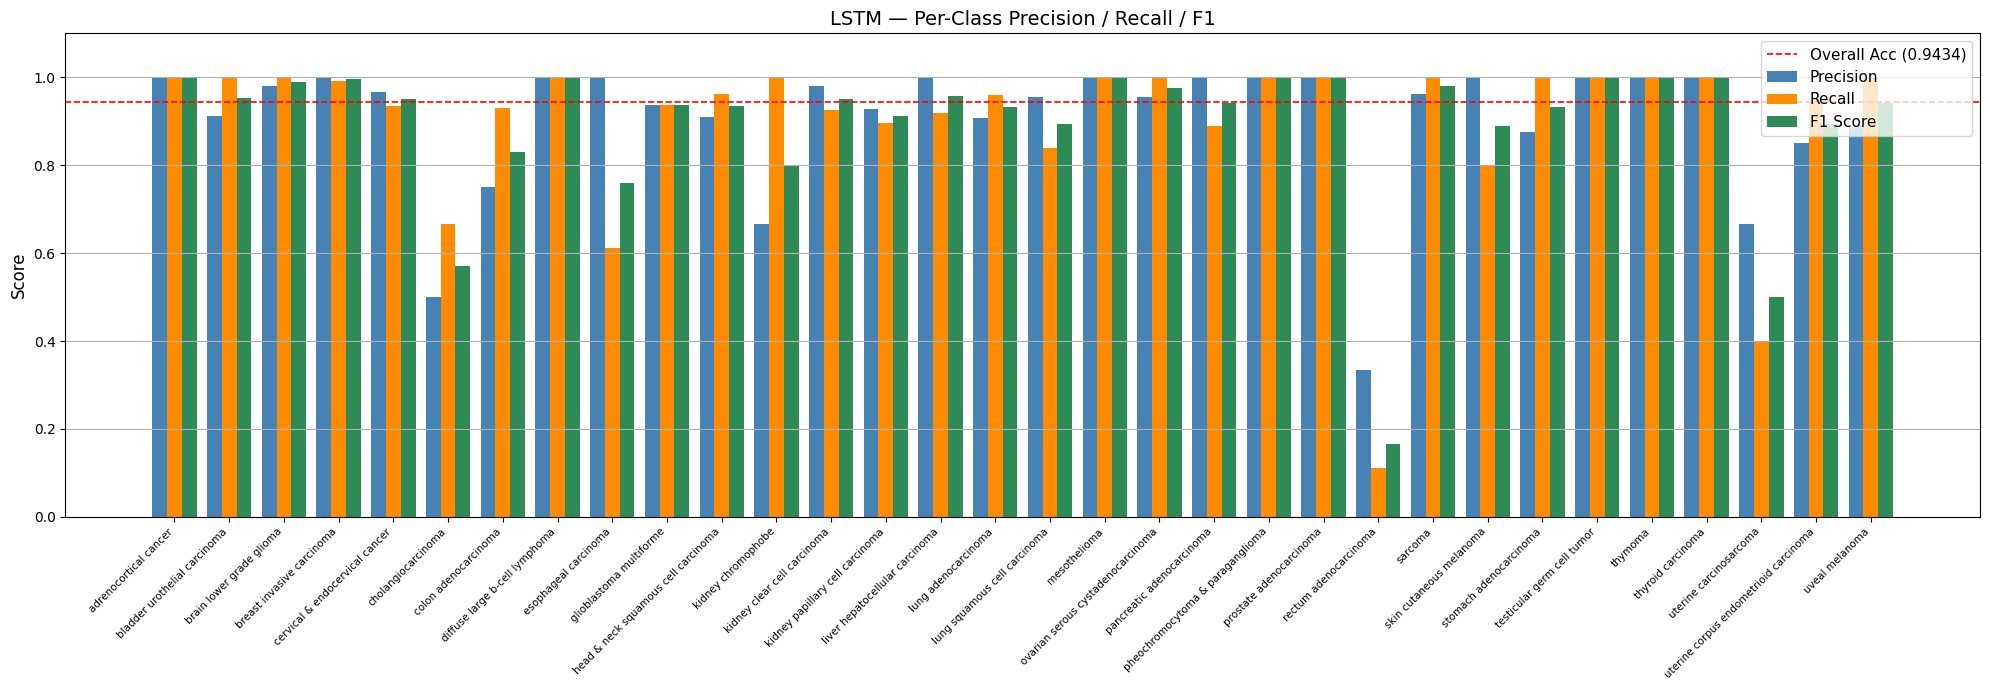

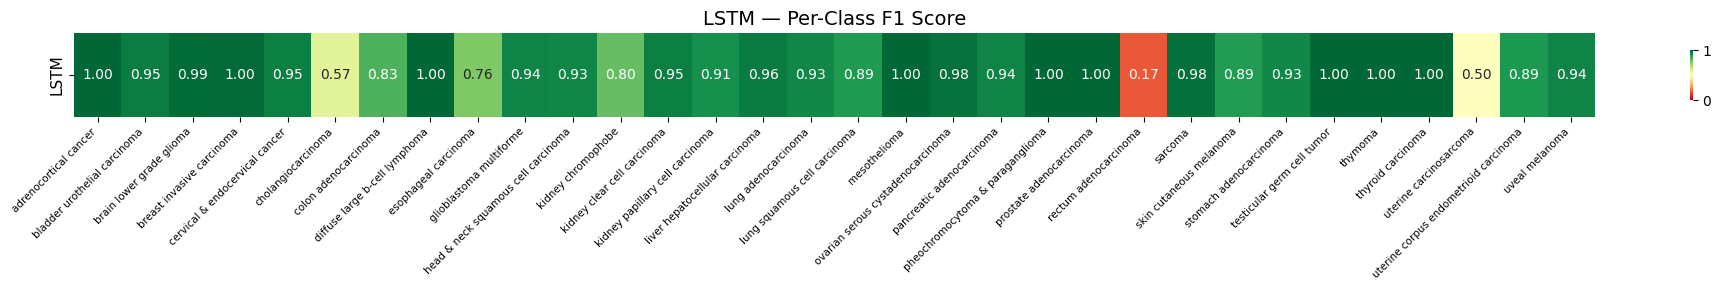

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, color="steelblue", linewidth=2)
axes[0].set_xlabel("Epoch");  axes[0].set_ylabel("Loss")
axes[0].set_title("LSTM — Training Loss");  axes[0].grid(True)

axes[1].plot(val_accs, color="darkorange", linewidth=2)
axes[1].axhline(y=best_val_acc, color="red", linestyle="--",
                label=f"Best ({best_val_acc:.4f})")
axes[1].set_xlabel("Epoch");  axes[1].set_ylabel("Accuracy")
axes[1].set_title("LSTM — Validation Accuracy")
axes[1].legend();  axes[1].grid(True)

plt.tight_layout()
plt.savefig("lstm_training_curves.png", dpi=150)
plt.show()

cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd",
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("Actual",    fontsize=13)
plt.title("LSTM — Confusion Matrix", fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=7.5)
plt.yticks(rotation=0,  fontsize=7.5)
plt.tight_layout()
plt.savefig("lstm_confusion_matrix.png", dpi=150)
plt.show()

precision = precision_score(all_true, all_preds, average=None, zero_division=0)
recall    = recall_score(   all_true, all_preds, average=None, zero_division=0)
f1        = f1_score(       all_true, all_preds, average=None, zero_division=0)

x_pos = np.arange(len(le.classes_))
width = 0.27

fig, ax = plt.subplots(figsize=(20, 7))
ax.bar(x_pos - width, precision, width, label="Precision", color="steelblue")
ax.bar(x_pos,         recall,   width, label="Recall",    color="darkorange")
ax.bar(x_pos + width, f1,       width, label="F1 Score",  color="seagreen")

ax.set_xticks(x_pos)
ax.set_xticklabels(le.classes_, rotation=45, ha="right", fontsize=7.5)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("LSTM — Per-Class Precision / Recall / F1", fontsize=14)
ax.axhline(y=test_acc, color="red", linestyle="--", linewidth=1.2,
           label=f"Overall Acc ({test_acc:.4f})")
ax.legend(fontsize=11);  ax.set_ylim(0, 1.1);  ax.grid(axis="y")
plt.tight_layout()
plt.savefig("lstm_per_class_metrics.png", dpi=150)
plt.show()

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(f1.reshape(1, -1), annot=True, fmt=".2f", cmap="RdYlGn",
            vmin=0, vmax=1, xticklabels=le.classes_, ax=ax,
            cbar_kws={"shrink": 0.6})
ax.set_yticklabels(["LSTM"], fontsize=11)
ax.set_xticklabels(le.classes_, rotation=45, ha="right", fontsize=7.5)
ax.set_title("LSTM — Per-Class F1 Score", fontsize=14)
plt.tight_layout()
plt.savefig("lstm_f1_heatmap.png", dpi=150)
plt.show()


In [15]:
SAVE_DIR = "/content/drive/MyDrive/lstm_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

checkpoint = {
    "model_state_dict":     model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "best_val_acc":         best_val_acc,
    "test_acc":             float(test_acc),
    "train_losses":         train_losses,
    "val_accs":             val_accs,
    "hyperparams": {
        "NUM_GENES":    NUM_GENES,
        "PROJ_DIM":     PROJ_DIM,
        "SEQ_LEN":      SEQ_LEN,
        "INPUT_SIZE":   INPUT_SIZE,
        "hidden_size":  128,
        "num_layers":   2,
        "dropout":      0.3,
        "num_classes":  NUM_CLASSES,
    }
}
torch.save(checkpoint, os.path.join(SAVE_DIR, "best_lstm_checkpoint.pt"))

np.savez(
    os.path.join(SAVE_DIR, "shared_splits.npz"),
    X_train=X_train, X_val=X_val, X_test=X_test,
    y_train=y_train, y_val=y_val, y_test=y_test
)

np.save(os.path.join(SAVE_DIR, "label_classes.npy"), le.classes_)

lstm_results = {
    "test_acc":       float(test_acc),
    "best_val_acc":   float(best_val_acc),
    "train_losses":   np.array(train_losses),
    "val_accs":       np.array(val_accs),
    "all_preds":      all_preds,
    "all_true":       all_true,
    "precision":      precision,
    "recall":         recall,
    "f1":             f1,
    "classes":        le.classes_,
    "num_params":     sum(p.numel() for p in model.parameters()),
}
np.savez(os.path.join(SAVE_DIR, "lstm_results.npz"), **lstm_results)

print(f"LSTM Final Summary")
print(f"Best Val Accuracy :{best_val_acc:.4f}")
print(f"Test Accuracy:{test_acc:.4f}")
print(f"Macro F1:{f1.mean():.4f}")
print(f"Weighted F1:{np.average(f1, weights=[np.sum(all_true == i) for i in range(NUM_CLASSES)]):.4f}")
print(f"Parameters:{lstm_results['num_params']:,}")
print(f"Num Genes (input):{NUM_GENES}")
print(f"Num Classes:{NUM_CLASSES}")

LSTM Final Summary
Best Val Accuracy :0.9521
Test Accuracy:0.9434
Macro F1:0.8936
Weighted F1:0.9404
Parameters:639,520
Num Genes (input):19800
Num Classes:32
